# LPI Tutorial

Get mean LPI for each REW channel

In [2]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import datetime
from datetime import timedelta
import numpy as np
import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import sys
import pickle
from functools import partial
import geopandas as gp

parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
import zonal_stats as zs
import meteolib as meteo
import evaplib as evap
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','4_temperature'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
from temperature import SimpleTemperature
from channel import SimpleChannel


try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print 'Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly'
basins = gp.read_file(basins)

rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
temperature_params = pickle.load( open( os.path.join(parent_dir, 'model_data', 'temperature_params.p'), 'rb'))
hill_groups = pickle.load( open( os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'), "rb" ) )
solved_channel_routing = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )
channel_params = pickle.load( open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ))

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_temperature']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
resample_freq_temperature = model_config['resample_freq_temperature']
t = np.linspace(0,Tmax,np.ceil(Tmax/dt)+1)
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)
timestamps_channel = pd.date_range(start_date, stop_date, freq=resample_freq_channel)
timestamps_temperature = pd.date_range(start_date, stop_date, freq=resample_freq_temperature)



In [4]:
lpi_files = glob.glob(os.path.join('/Volumes/zee_data/lpi','*.tif'))
points_file = glob.glob(os.path.join(parent_dir, 'raw_data','streams_points','*.shp'))[0]
points = gp.read_file(points_file)

mean_lpis = {i:0 for i in basins.cat}
for raster_file in lpi_files:
    lpis_dict = {i:[] for i in basins.cat}
    filename = raster_file.split('/')[-1]
    mind = filename.index('m')
    month = int(filename[(mind+1):(mind+3)])
    # get raster as numpy array
    gdata = gdal.Open(raster_file)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    
    # loop over basins, get points within each basin
    for basinindex, basinrow in basins.iterrows():
        for index, row in points.iterrows():
            if row.geometry.within(basinrow.geometry):
                pos = (row.geometry.x, row.geometry.y)
                x = int((pos[0] - gt[0])/gt[1])
                y = int((pos[1] - gt[3])/gt[5])
                lpis_dict[basinrow['cat']].append(data[x,y])
    
    lpis_means = {i:np.mean(lpis_dict[i]) for i in lpis_dict.keys()}
    for basin_index in lpis_means.keys():
        mean_lpis[basin_index] = mean_lpis[basin_index] + lpis_means[basin_index]/12.0
        
pickle.dump(mean_lpis, open(os.path.join(parent_dir, 'raw_data', 'mean_rew_lpis.p'), 'wb'))

In [5]:
mean_lpis

{1: 0.10246279145916545, 2: 0.096578969382772273, 3: 0.11468458363149117}

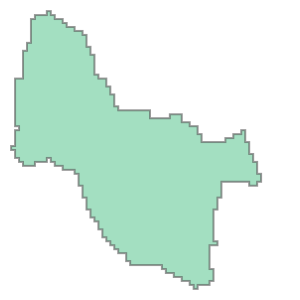

In [6]:
basinrow.geometry